# XYZLoader TLS Demo

Notebook: Hannah Weiser, 2026

This demo shows how to load a point cloud as scene part, which is then converted to a voxel model by HELIOS++. The example point cloud is a sphere, and we will scan it with terrestrial laser scanning (TLS).

## Imports

In [1]:
import helios
import numpy as np
import matplotlib.pyplot as plt

## Creating the virtual scene

This scene consists of a simple ground plane loaded from an OBJ file and a point cloud of a sphere which is loaded from an XYZ file. HELIOS++ is transforming this point cloud into a voxel model, which is then scanned. The size of the voxels is determined by the value provided to the parameter `voxel_size`, here 1.0 meters.

Furthermore, we tell HELIOS++ to estimate normals for each voxel by setting `estimate_normals` to 1. This means that not the normal vector of the outer surface of each voxel cube is used, but instead the normal vector computed from the points within the voxel. These normal vectors determine the incidence angle of the beam, which in return influences the intensity that is computed for the generated return.

In [2]:
# load objs and create transformations
groundplane = helios.ScenePart.from_obj("../data/sceneparts/basic/groundplane/groundplane.obj").scale(100)
sphere = helios.ScenePart.from_xyz("../data/sceneparts/pointclouds/sphere_dens25000.xyz",
                                  voxel_size=1.0,
                                  separator=" ",
                                  estimate_normals=1,
                                  ).translate([0.0, 0.0, 10.0])

# create scene
scene = helios.StaticScene(scene_parts=[groundplane, sphere])

## Platform and scanner

HELIOS++ comes with a wide range of pre-defined scanners and platforms, which we can import and instantiate from the `scanner` and `platforms` submodules by their ID. We use the `tripod` platform (a simple static platform with the scanner mounted at a height of 1.5 m), and the RIEGL VZ-400 TLS.

In [3]:
scanner = helios.scanner_from_name("riegl_vz_400")
platform = helios.platform_from_name("tripod")

## Scan positions and scanner settings

In [4]:
survey = helios.Survey(scanner=scanner, platform=platform, scene=scene)
# first scan position
survey.add_leg(x=40.0,
               y=-10.0,
               z=0.0,
               force_on_ground=True,  # this works because of the specification in the groundplane.mtl file,
               pulse_frequency=100_000 * helios.units.Hz,
               scan_frequency=120 * helios.units.Hz,
               min_vertical_angle=-40 * helios.units.deg,
               max_vertical_angle=60 * helios.units.deg,
               rotation_start_angle=250 * helios.units.deg,
               rotation_stop_angle=380 * helios.units.deg,
               head_rotation="10 deg/s"
              )

## Executing the survey

In [6]:
points, _ = survey.run(verbosity=helios.LogVerbosity.VERBOSE, format=helios.OutputFormat.NPY)

## Visualizing the result

Finally, let's visualize the simulated points using `matplotlib`.

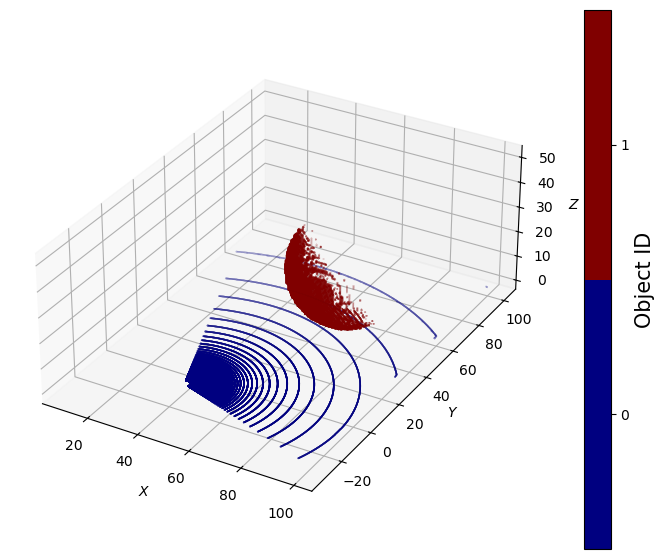

In [7]:
coords = points["position"]
object_id = points["hit_object_id"]

# Matplotlib figures.
fig = plt.figure(figsize=(9, 7))

# settings for a discrete colorbar
N = 2
cmap = plt.get_cmap("jet", N)

# Scatter plot of the point cloud (coloured by hitObjectId).
ax = fig.add_subplot(projection="3d")
sc = ax.scatter(
    coords[:, 0],
    coords[:, 1],
    coords[:, 2],
    c=object_id,
    cmap=cmap,
    s=0.02,
    label="scene",
)

# Add axis labels.
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.set_zlabel("$Z$")

# set equal axes
box = (np.ptp(coords[:, 0]), np.ptp(coords[:, 1]), np.ptp(coords[:, 2]))
ax.set_box_aspect(box)

cbar = plt.colorbar(sc, ticks=[1 / 4, 3 / 4])

cbar.set_label("Object ID", fontsize=15)
cbar.ax.set_yticklabels(["0", "1"])

# Display results
plt.show()

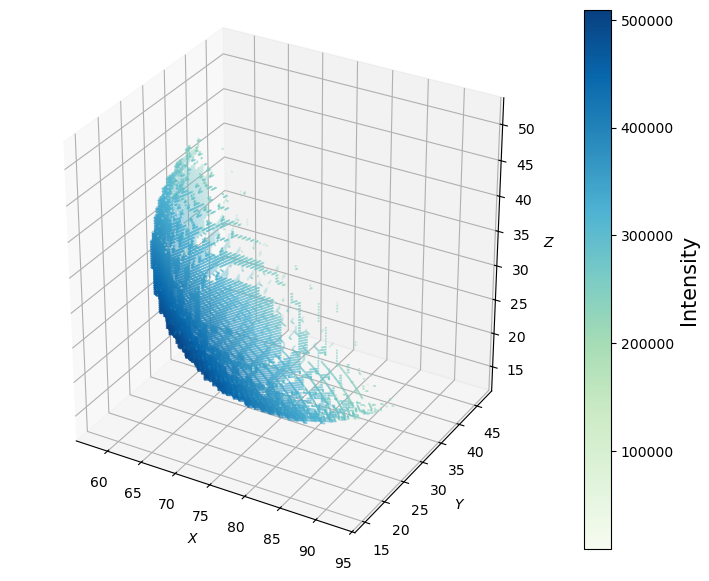

In [8]:
# select only points with object ID = 1
sphere_idx = object_id == 1

# get coords and intensities
sphere_coords = coords[sphere_idx, :]
sphere_intensities = points["intensity"][sphere_idx]

# Matplotlib figures.
fig = plt.figure(figsize=(9, 7))

# Scatter plot of only the sphere point cloud (coloured by Intensity).
ax = fig.add_subplot(projection="3d")
sc = ax.scatter(
    sphere_coords[:, 0],
    sphere_coords[:, 1],
    sphere_coords[:, 2],
    c=sphere_intensities,
    cmap="GnBu",
    s=0.1,
    label="scene",
)

# Add axis labels.
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.set_zlabel("$Z$")

# set equal axes
box = (
    np.ptp(sphere_coords[:, 0]),
    np.ptp(sphere_coords[:, 1]),
    np.ptp(sphere_coords[:, 2]),
)
ax.set_box_aspect(box)

cbar = plt.colorbar(sc)

cbar.set_label("Intensity", fontsize=15)

plt.show()